In [191]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest,VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import  DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
import pickle
import keras 
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [101]:
df = pd.read_csv("../Data/Train/Train.csv",index_col=0)

In [102]:
X = df.drop(columns=["income"])
y = df["income"]

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(31644, 35)
(7912, 35)
(31644,)
(7912,)


Empezamos con modelos simples de clasificación. 

In [ ]:
pipe = Pipeline(steps=[
    ('scaler',StandardScaler()),
    ('feat',SelectKBest(k=10)),
    ('class',LogisticRegression(max_iter=10000))

])

RLparams = {
    'scaler':[StandardScaler(),MinMaxScaler(),'passthrough'],
    'feat':[SelectKBest()],
    'feat__k':[5,10,15,20,30,'all'],
    'class':[LogisticRegression(max_iter=10000)],
    'class__C':[0.1,0.2,0.3,0.5,1]
}
DTparams = {
    'scaler':[StandardScaler(),MinMaxScaler(),'passthrough'],
    'feat':[SelectKBest()],
    'feat__k':[5,10,15,20,30,'all'],
    'class':[DecisionTreeClassifier()],
    'class__max_depth':np.arange(3,11),
    'class__min_samples_split':[30,50,70],
    'class__min_samples_leaf':[20,60,80]
}
KNNparams = {
    'scaler':[StandardScaler(),MinMaxScaler(),'passthrough'],
    'feat':[SelectKBest()],
    'feat__k':[5,10,15,20,30,'all'],
    'class':[KNeighborsClassifier()],
    'class__n_neighbors':[50,100,1000,4000]
}


busqueda = [RLparams,DTparams,KNNparams]

rs = RandomizedSearchCV(estimator=pipe,param_distributions=busqueda,cv=5,n_iter=150,verbose=2,scoring="recall")
rs.fit(x_train,y_train)

In [104]:
print(rs.best_estimator_)
print(rs.best_score_)
print(rs.best_params_)

Pipeline(steps=[('scaler', StandardScaler()), ('feat', SelectKBest(k=20)),
                ('class', KNeighborsClassifier(n_neighbors=4000))])
0.9478304950323985
{'scaler': StandardScaler(), 'feat__k': 20, 'feat': SelectKBest(), 'class__n_neighbors': 4000, 'class': KNeighborsClassifier()}


In [105]:
modelo_basico = rs.best_estimator_
modelo_basico.fit(x_train,y_train)
y_pred = modelo_basico.predict(x_test)

Evaluacion del primer modelo

In [106]:
print(accuracy_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(precision_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.8248230535894844
0.9371846619576185
0.7656636438582028
[[2811 1137]
 [ 249 3715]]


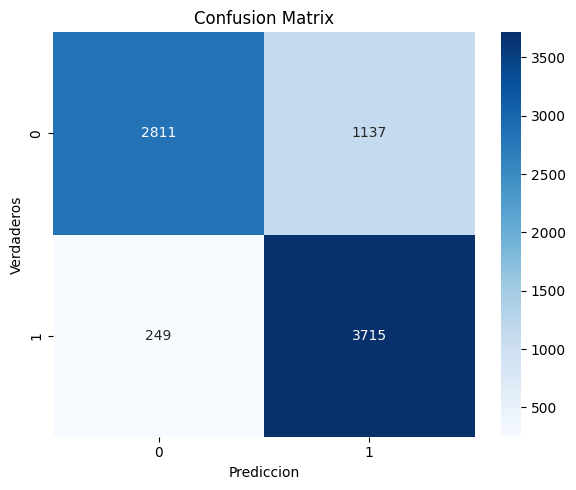

In [107]:
labels = np.unique(y_test)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prediccion')
plt.ylabel('Verdaderos')
plt.title('Confusion Matrix')
plt.tight_layout()

In [108]:
X.columns[modelo_basico.named_steps["feat"].get_support()]

Index(['age', 'education-num', 'capital-gain', 'hours-per-week', 'extras',
       'marital-status_Casado/a (civil)', 'marital-status_Nunca casado/a',
       'race_ White', 'occ_ord', 'sex_ Female', 'sex_ Male',
       'educacion_superior', 'educacion_inferior', 'edad_ajustada',
       'horas_puesto', 'edu_oc', 'rango_edad', 'horas_ord_Jornada_larga',
       'rel_ord', 'cluster'],
      dtype='object')

In [109]:
filename = "../models/modelo_DT.pkl"
with open(filename,"wb")as archivo:
    pickle.dump(modelo_basico,archivo)

Probamos con un Random Forest 

In [110]:
pipe2 = Pipeline(steps=[
    ("scaler",StandardScaler()),
    ("class",RandomForestClassifier())
])

params = {
    'scaler':[StandardScaler(),MinMaxScaler(),'passthrough'],
    'class__max_depth': np.arange(3,12),
    'class__n_estimators': [50,150,200],
    'class__min_samples_split':[30,50,70],
    'class__min_samples_leaf':[20,60,80]
}

gs = GridSearchCV(estimator=pipe2,param_grid=params,cv=5,verbose=2,scoring='recall',n_jobs=-1)
gs.fit(x_train,y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('class', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'class__max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11]),
                         'class__min_samples_leaf': [20, 60, 80],
                         'class__min_samples_split': [30, 50, 70],
                         'class__n_estimators': [50, 150, 200],
                         'scaler': [StandardScaler(), MinMaxScaler(),
                                    'passthrough']},
             scoring='recall', verbose=2)

In [111]:
print(gs.best_estimator_)
print(gs.best_score_)
print(gs.best_params_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('class',
                 RandomForestClassifier(max_depth=3, min_samples_leaf=20,
                                        min_samples_split=30,
                                        n_estimators=50))])
0.9155168383325304
{'class__max_depth': 3, 'class__min_samples_leaf': 20, 'class__min_samples_split': 30, 'class__n_estimators': 50, 'scaler': StandardScaler()}


In [112]:
modeloRF = gs.best_estimator_
modeloRF.fit(x_train,y_train)
y_pred = modeloRF.predict(x_test)

Evaluación de modelo Rf

Funcion para evaluar más rápido

In [113]:
def evaluar_modelo (y_test,y_pred):
    print("acc score:",accuracy_score(y_test,y_pred))
    print("recallscore",recall_score(y_test,y_pred))
    print("precision score:",precision_score(y_test,y_pred))
    labels = np.unique(y_test)
    return plt.figure(figsize=(6, 5)),sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels),plt.xlabel('Prediccion'),plt.ylabel('Verdaderos'),plt.title('Confusion Matrix'),plt.tight_layout()

acc score: 0.8490899898887766
recallscore 0.9134712411705348
precision score: 0.8097048300536672


(<Figure size 600x500 with 2 Axes>,
 <Axes: title={'center': 'Confusion Matrix'}, xlabel='Prediccion', ylabel='Verdaderos'>,
 Text(0.5, 25.722222222222214, 'Prediccion'),
 Text(45.722222222222214, 0.5, 'Verdaderos'),
 Text(0.5, 1.0, 'Confusion Matrix'),
 None)

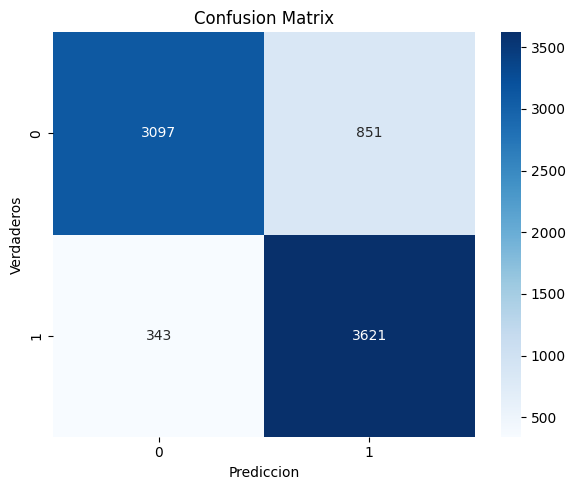

In [114]:
evaluar_modelo(y_test,y_pred)

In [115]:
importancias = np.round(modeloRF.named_steps['class'].feature_importances_,2)
nombres = X.columns
df_imp = pd.DataFrame({
    "variable": nombres,
    "Importancia": importancias
    
})
df_imp.sort_values(by="Importancia",ascending=False).head(10).set_index("variable")

,Importancia
variable,
marital-status_Casado/a (civil),0.23
cluster,0.17
edad_ajustada,0.09
rel_ord,0.08
horas_puesto,0.08
educacion_inferior,0.07
horas_ord_Jornada_larga,0.05
edu_oc,0.04
age,0.04


Función para ver importancias

In [116]:
def ver_importancias (modelo):
    importancias = np.round(modelo.named_steps['class'].feature_importances_,2)
    nombres = X.columns
    df_imp = pd.DataFrame({
    "variable": nombres,
    "Importancia": importancias})
    return df_imp.sort_values(by="Importancia",ascending=False).head(10).set_index("variable")

In [117]:
filename = "../models/modelo_RF.pkl"
with open(filename,"wb")as archivo:
    pickle.dump(modeloRF,archivo)

Xgboost

In [118]:
pipe3 = Pipeline(steps=[
    ("scaler",StandardScaler()),
    ("class",XGBClassifier())
])

params = {
    'scaler':[StandardScaler(),MinMaxScaler(),'passthrough'],
    'class__max_depth': np.arange(3,12),
    'class__n_estimators': [50,150,200],
    'class__learning_rate': [0.05,0.1,0.3],
    'class__objective':["binary:logistic"]
}

gs = GridSearchCV(estimator=pipe3,param_grid=params,cv=10,verbose=2,scoring='recall',n_jobs=-1)
gs.fit(x_train,y_train)

Fitting 10 folds for each of 243 candidates, totalling 2430 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('class',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      feature_weights=None,
                                                      gamma=None,
                                                      grow_policy...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'class__learning_rate': [0.05, 0.1, 0.3],
                         'class__max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11]),
                         'class__n_estimators': [50, 150, 200],
                         'class__objective': ['binary:logistic'],
                         'scaler': [StandardScaler(), MinMaxScaler(),
                                    'passthrough']},
             scoring='recall', verbose=2)

In [119]:
modeloXG = gs.best_estimator_
modeloXG.fit(x_train,y_train)
y_pred = modeloXG.predict(x_test)

Evaluacion XG

acc score: 0.8661526794742164
recallscore 0.8990918264379415
precision score: 0.8439497987212882


(<Figure size 600x500 with 2 Axes>,
 <Axes: title={'center': 'Confusion Matrix'}, xlabel='Prediccion', ylabel='Verdaderos'>,
 Text(0.5, 25.722222222222214, 'Prediccion'),
 Text(45.722222222222214, 0.5, 'Verdaderos'),
 Text(0.5, 1.0, 'Confusion Matrix'),
 None)

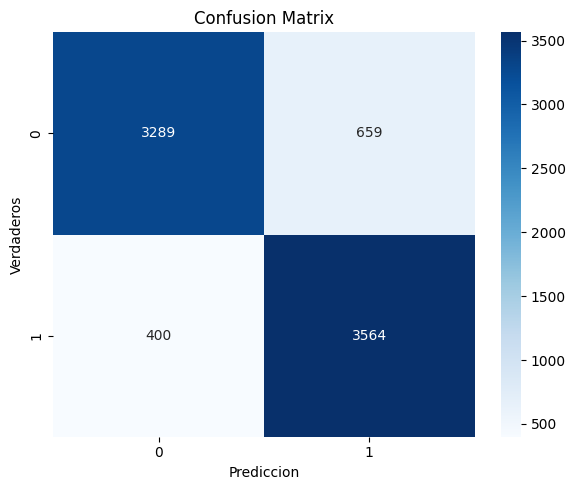

In [120]:
evaluar_modelo(y_test,y_pred)

In [122]:
ver_importancias(modeloXG)

,Importancia
variable,
marital-status_Casado/a (civil),0.37
educacion_inferior,0.18
horas_ord_Jornada_media,0.05
horas_ord_Jornada_larga,0.04
horas_puesto,0.04
sex_ Female,0.04
sex_ Male,0.04
rel_ord,0.03
extras,0.03


In [123]:
filename = "../models/modelo_XG.pkl"
with open(filename,"wb")as archivo:
    pickle.dump(modeloXG,archivo)

Catboost

In [ ]:
pipe4 = Pipeline(steps=[
    ("scaler",StandardScaler()),
    ("class",CatBoostClassifier())
])

params = {
    'scaler':[StandardScaler(),MinMaxScaler(),'passthrough'],
    'class__depth': np.arange(3,12),
    'class__iterations': [100, 300, 500],
    'class__learning_rate':  [0.01, 0.05, 0.1, 0.2],
    'class__l2_leaf_reg':[1, 3, 5, 7, 10],
    'class__bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
    'class__subsample': [0.6, 0.8, 1.0],
    'class__auto_class_weights': ['Balanced', None]
}

Rs2 = RandomizedSearchCV(n_iter=50,estimator=pipe4,param_distributions=params,cv=10,verbose=2,scoring='recall',n_jobs=-1)
Rs2.fit(x_train,y_train)

In [ ]:
modeloCAT = Rs2.best_estimator_
modeloCAT.fit(x_train,y_train)
y_pred = modeloCAT.predict(x_test)

Evaluación de Catboost

acc score: 0.9058392315470172
recallscore 0.8950554994954592
precision score: 0.9151405726076863


(<Figure size 600x500 with 2 Axes>,
 <Axes: title={'center': 'Confusion Matrix'}, xlabel='Prediccion', ylabel='Verdaderos'>,
 Text(0.5, 25.722222222222214, 'Prediccion'),
 Text(45.722222222222214, 0.5, 'Verdaderos'),
 Text(0.5, 1.0, 'Confusion Matrix'),
 None)

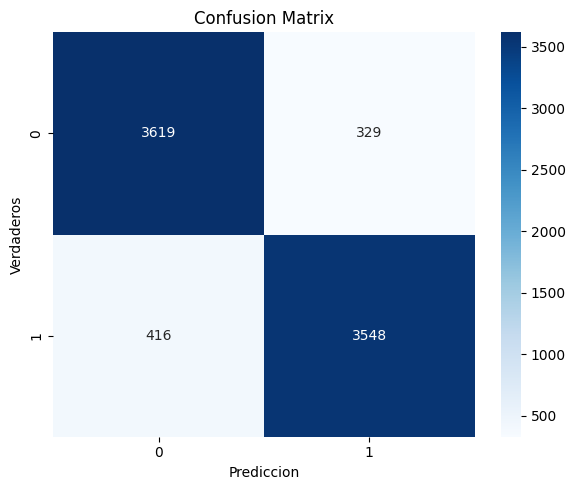

In [127]:
evaluar_modelo(y_test,y_pred)

In [128]:
ver_importancias(modeloCAT)

,Importancia
variable,
horas_ord_Jornada_media,11.62
marital-status_Casado/a (civil),10.65
horas_ord_Jornada_larga,7.76
hours-per-week,6.79
capital-gain,6.31
educacion_inferior,5.26
education-num,5.25
horas_puesto,4.86
age,4.77


In [ ]:
scores = cross_val_score(estimator = modeloCAT,X=x_train,y=y_train,scoring = 'recall',cv=10)


In [135]:
print(scores)
print(scores.mean())
print(scores.std())

[0.89064475 0.89570164 0.89633375 0.9045512  0.8969007  0.88361796
 0.91334598 0.88108792 0.89184061 0.88235294]
0.8936377462775006
0.009628716626493396


In [129]:
filename = "../models/modelo_CAT.pkl"
with open(filename,"wb")as archivo:
    pickle.dump(modeloCAT,archivo)

LightGBM

In [137]:
pipe5 = Pipeline(steps=[
    ("scaler",StandardScaler()),
    ("class",LGBMClassifier())
])

params = {
    'scaler':[StandardScaler(),MinMaxScaler(),'passthrough'],
    'class__max_depth': [3,5,7,9,11,15],
    'class__n_estimators': [100, 300, 500],
    'class__learning_rate':  [0.01, 0.05, 0.1, 0.2],
    'class__min_child_samples': [10, 20, 30],
    'class__subsample': [0.6, 0.8, 1.0],
    'class__colsample_bytree': [0.6, 0.8, 1.0],
    'class__reg_alpha': [0.0, 0.1, 0.5],
    'class__reg_lambda': [0.0, 0.1, 0.5],
    'class__boosting_type': ['gbdt', 'dart']
}

Rs3 = RandomizedSearchCV(n_iter=50,estimator=pipe5,param_distributions=params,cv=5,verbose=2,scoring='recall',n_jobs=-1)
Rs3.fit(x_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 15814, number of negative: 15830
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 31644, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499747 -> initscore=-0.001011
[LightGBM] [Info] Start training from score -0.001011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('class', LGBMClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'class__boosting_type': ['gbdt',
                                                                 'dart'],
                                        'class__colsample_bytree': [0.6, 0.8,
                                                                    1.0],
                                        'class__learning_rate': [0.01, 0.05,
                                                                 0.1, 0.2],
                                        'class__max_depth': [3, 5, 7, 9, 11,
                                                             15],
                                        'class__min_child_samples': [10, 20,
                                                                     30],
                                        'class__n_estimators': [100, 300, 500],
                                        'class__reg_alpha': [0.0, 0.1, 0.5],
                                        'class__reg_lambda': [0.0, 0.1, 0.5],
                                        'class__subsample': [0.6, 0.8, 1.0],
                                        'scaler': [StandardScaler(),
                                                   MinMaxScaler(),
                                                   'passthrough']},
                   scoring='recall', verbose=2)

In [138]:
print(Rs3.best_estimator_)
print(Rs3.best_score_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('class',
                 LGBMClassifier(boosting_type='dart', colsample_bytree=0.6,
                                learning_rate=0.05, max_depth=3,
                                min_child_samples=10, reg_alpha=0.5,
                                subsample=0.6))])
0.8980015409833377


In [139]:
modeloLGBM = Rs3.best_estimator_
modeloLGBM.fit(x_train,y_train)
y_pred = modeloLGBM.predict(x_test)

[LightGBM] [Info] Number of positive: 15814, number of negative: 15830
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 31644, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499747 -> initscore=-0.001011
[LightGBM] [Info] Start training from score -0.001011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\rafac\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Evaluacion LGBM

acc score: 0.8653943377148635
recallscore 0.898335015136226
precision score: 0.8432394032678191


(<Figure size 600x500 with 2 Axes>,
 <Axes: title={'center': 'Confusion Matrix'}, xlabel='Prediccion', ylabel='Verdaderos'>,
 Text(0.5, 25.722222222222214, 'Prediccion'),
 Text(45.722222222222214, 0.5, 'Verdaderos'),
 Text(0.5, 1.0, 'Confusion Matrix'),
 None)

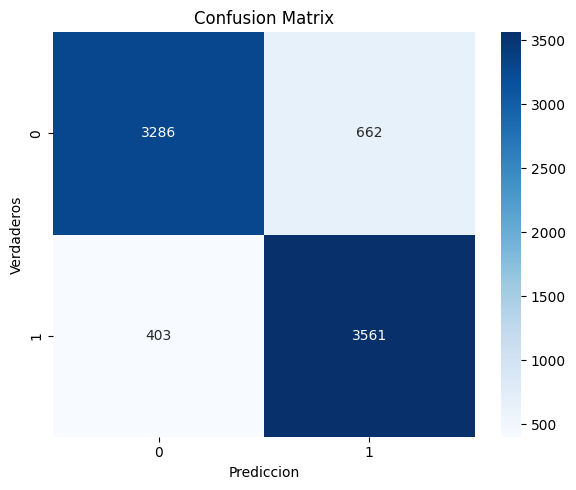

In [140]:
evaluar_modelo(y_test,y_pred)

In [141]:
ver_importancias(modeloLGBM)

,Importancia
variable,
horas_puesto,106
capital-gain,103
edad_ajustada,85
extras,65
marital-status_Casado/a (civil),63
educacion_inferior,50
hours-per-week,40
rel_ord,38
age,35


In [ ]:
scores = cross_val_score(estimator = modeloLGBM,X=x_train,y=y_train,scoring = 'recall',cv=10)

In [143]:
print(scores)
print(scores.mean())
print(scores.std())

[0.89001264 0.89759798 0.90328698 0.90012642 0.89373814 0.88994307
 0.91714105 0.89816572 0.88867805 0.90006325]
0.8978753305490053
0.00798071661696632


In [146]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      3948
           1       0.84      0.90      0.87      3964

    accuracy                           0.87      7912
   macro avg       0.87      0.87      0.87      7912
weighted avg       0.87      0.87      0.87      7912



In [148]:
filename = "../models/modelo_LGBM.pkl"
with open(filename,"wb")as archivo:
    pickle.dump(modeloLGBM,archivo)

PRUEBAS DE VALORACION DE MODELOS CON EL DATASET DE TEST

In [152]:
PRUEBA = pd.read_csv('../Data/Test/Test.csv',index_col=0)

In [223]:
x_prueba = PRUEBA.drop(columns=["income"])
y_prueba = PRUEBA["income"]

pred_prueba = modeloCAT.predict(x_prueba)

acc score: 0.8710271764163979
recallscore 0.7001909611712285
precision score: 0.7488087134104833


(<Figure size 600x500 with 2 Axes>,
 <Axes: title={'center': 'Confusion Matrix'}, xlabel='Prediccion', ylabel='Verdaderos'>,
 Text(0.5, 25.722222222222214, 'Prediccion'),
 Text(45.722222222222214, 0.5, 'Verdaderos'),
 Text(0.5, 1.0, 'Confusion Matrix'),
 None)

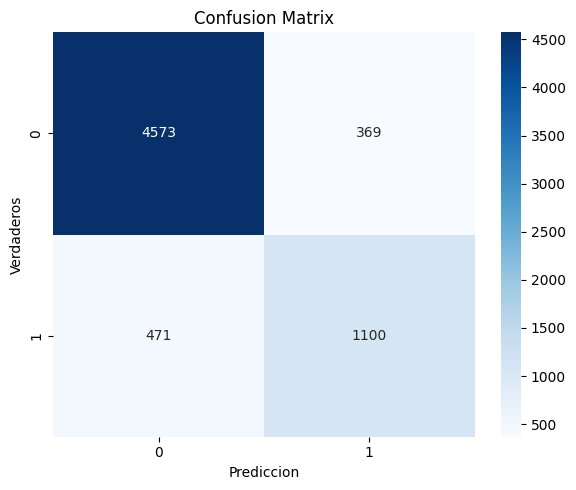

In [224]:
evaluar_modelo(y_prueba,pred_prueba)

Aunque las métricas son más bajas con TEST mantenemos una buena generalización

SVC

In [174]:
pipe6 = Pipeline(steps=[
    ("scaler",StandardScaler()),
    ('feat',SelectKBest()),
    ("class",SVC(max_iter=2000))
])

params = {
    'scaler':[StandardScaler(),MinMaxScaler(),'passthrough'],
    'feat__k':[5,10,15,20,30,'all'],
    'class__C': [0.01,0.1,1,5,10],
    'class__kernel': ['linear', 'rbf'],
    'class__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'class__class_weight': [None, 'balanced']
}

Rs4 = RandomizedSearchCV(n_iter=80,estimator=pipe6,param_distributions=params,cv=5,verbose=2,scoring='accuracy',n_jobs=-1)
Rs4.fit(x_train,y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


c:\Users\rafac\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('feat', SelectKBest()),
                                             ('class', SVC(max_iter=2000))]),
                   n_iter=80, n_jobs=-1,
                   param_distributions={'class__C': [0.01, 0.1, 1, 5, 10],
                                        'class__class_weight': [None,
                                                                'balanced'],
                                        'class__gamma': ['scale', 'auto', 0.001,
                                                         0.01, 0.1, 1],
                                        'class__kernel': ['linear', 'rbf'],
                                        'feat__k': [5, 10, 15, 20, 30, 'all'],
                                        'scaler': [StandardScaler(),
                                                   MinMaxScaler(),
                                                   'passthrough']},
                   scoring='accuracy', verbose=2)

In [175]:
print(Rs4.best_estimator_)
print(Rs4.best_score_)

Pipeline(steps=[('scaler', StandardScaler()), ('feat', SelectKBest(k=20)),
                ('class', SVC(C=5, max_iter=2000))])
0.7991713240218855


In [176]:
modeloSVC = Rs4.best_estimator_
modeloSVC.fit(x_train,y_train)
y_pred = modeloSVC.predict(x_prueba)

c:\Users\rafac\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [182]:
pipe7 = Pipeline(steps=[
    ("scaler",StandardScaler()),
    ('feat',SelectKBest(k=20)),
    ("class",SVC(max_iter=1000000))
])

params = {
    'class__C': [0.01,0.1,1,3],
    'class__kernel': ['rbf'],
    'class__gamma': [ 0.001, 0.01, 0.1, 1],
    'class__class_weight': ['balanced']
}

Rs5 = RandomizedSearchCV(n_iter=50,estimator=pipe7,param_distributions=params,cv=5,verbose=2,scoring='accuracy')
Rs5.fit(x_train,y_train)

c:\Users\rafac\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 16 is smaller than n_iter=50. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END class__C=0.01, class__class_weight=balanced, class__gamma=0.001, class__kernel=rbf; total time=  29.1s
[CV] END class__C=0.01, class__class_weight=balanced, class__gamma=0.001, class__kernel=rbf; total time=  29.4s
[CV] END class__C=0.01, class__class_weight=balanced, class__gamma=0.001, class__kernel=rbf; total time=  29.0s
[CV] END class__C=0.01, class__class_weight=balanced, class__gamma=0.001, class__kernel=rbf; total time=  28.9s
[CV] END class__C=0.01, class__class_weight=balanced, class__gamma=0.001, class__kernel=rbf; total time=  28.4s
[CV] END class__C=0.01, class__class_weight=balanced, class__gamma=0.01, class__kernel=rbf; total time=  18.6s
[CV] END class__C=0.01, class__class_weight=balanced, class__gamma=0.01, class__kernel=rbf; total time=  18.9s
[CV] END class__C=0.01, class__class_weight=balanced, class__gamma=0.01, class__kernel=rbf; total time=  19.7s
[CV] END class__C=0.01, class__class_weight=ba

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('feat', SelectKBest(k=20)),
                                             ('class', SVC(max_iter=1000000))]),
                   n_iter=50,
                   param_distributions={'class__C': [0.01, 0.1, 1, 3],
                                        'class__class_weight': ['balanced'],
                                        'class__gamma': [0.001, 0.01, 0.1, 1],
                                        'class__kernel': ['rbf']},
                   scoring='accuracy', verbose=2)

In [183]:
print(Rs5.best_estimator_)
print(Rs5.best_score_)

Pipeline(steps=[('scaler', StandardScaler()), ('feat', SelectKBest(k=20)),
                ('class',
                 SVC(C=3, class_weight='balanced', gamma=0.1,
                     max_iter=1000000))])
0.888288358785907


In [184]:
modeloSVC = Rs5.best_estimator_
modeloSVC.fit(x_train,y_train)
y_pred = modeloSVC.predict(x_prueba)

Valoramos SVC

acc score: 0.8436972209427299
recallscore 0.668364099299809
precision score: 0.6787330316742082


(<Figure size 600x500 with 2 Axes>,
 <Axes: title={'center': 'Confusion Matrix'}, xlabel='Prediccion', ylabel='Verdaderos'>,
 Text(0.5, 25.722222222222214, 'Prediccion'),
 Text(45.722222222222214, 0.5, 'Verdaderos'),
 Text(0.5, 1.0, 'Confusion Matrix'),
 None)

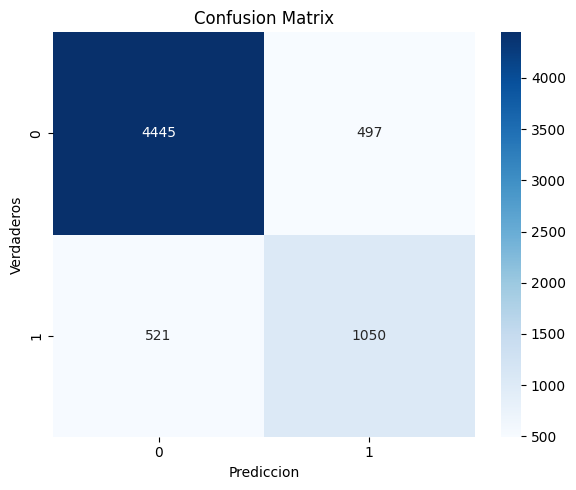

In [185]:
evaluar_modelo(y_prueba,y_pred)

In [186]:
filename = "../models/modelo_SVC.pkl"
with open(filename,"wb")as archivo:
    pickle.dump(modeloSVC,archivo)

Modelos de Redes Neuronales

In [190]:
x_train.shape[1:]

(35,)

In [211]:
modelRN = keras.Sequential([
    keras.Input(shape=(35,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(12, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  
])


modelRN.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

history = modelRN.fit(
    x_train, y_train,
    epochs=1000,
    batch_size=320,
    validation_split=0.2, 
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5165 - loss: 608.0248 - precision_19: 0.4999 - recall_19: 0.4483 - val_accuracy: 0.5557 - val_loss: 100.9161 - val_precision_19: 0.9616 - val_recall_19: 0.1254
Epoch 2/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5389 - loss: 72.6745 - precision_19: 0.5567 - recall_19: 0.4971 - val_accuracy: 0.5017 - val_loss: 78.9583 - val_precision_19: 0.5034 - val_recall_19: 0.9928
Epoch 3/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5291 - loss: 49.2858 - precision_19: 0.5283 - recall_19: 0.5687 - val_accuracy: 0.5865 - val_loss: 27.9169 - val_precision_19: 0.8984 - val_recall_19: 0.2046
Epoch 4/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5419 - loss: 85.6891 - precision_19: 0.5479 - recall_19: 0.5234 - val_accuracy: 0.5047 - val_loss: 90.0266 - val_precision_19: 0.5049 - val_recall_19: 0.9991
Epoch 5/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5342 - loss: 80.4280 - precision_19:

In [212]:
y_pred = modelRN.predict(x_prueba)


204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step


In [218]:
modelRN.evaluate(x_prueba,y_prueba)

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7846 - loss: 0.6241 - precision_19: 0.6973 - recall_19: 0.2229


[0.6251735091209412,
 0.7878090143203735,
 0.6924643516540527,
 0.2164226621389389]

In [219]:
filename = "../models/modelo_RN.pkl"
with open(filename,"wb")as archivo:
    pickle.dump(modelRN,archivo)

RESULTADOS

In [ ]:
modelos = [modeloSVC,modeloCAT,modeloLGBM,modelo_basico,modeloRF,modeloXG]

resultados = {
    'accuracy':[],
    'recall':[],
    'precision':[]
}


for modelo in modelos:
    pred_prueba = modelo.predict(x_prueba)
    resultados['accuracy'].append(accuracy_score(y_prueba,pred_prueba))
    resultados['recall'].append(recall_score(y_prueba,pred_prueba))
    resultados['precision'].append(precision_score(y_prueba,pred_prueba))



In [230]:
df_resultados = pd.DataFrame(resultados,index=['SVC','CAT','LGBM','DT','RF','XG'])

In [231]:
df_resultados

,accuracy,recall,precision
SVC,0.843697,0.668364,0.678733
CAT,0.871027,0.700191,0.748809
LGBM,0.823123,0.735201,0.610788
DT,0.761093,0.854870,0.502808
RF,0.800246,0.792489,0.560811
XG,0.823584,0.737747,0.611287
